In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
### print(tf.__version__)

## 파일 가져오기 및 데이터셋 분리

In [ ]:
train = pd.read_csv("./data/test_data0413.csv", encoding = 'euc-kr')
train

In [4]:
test = train[12000:]
train =train[:12000]

In [5]:
train['Feeling'].value_counts()

5.0    4693
2.0    3259
0.0    2086
1.0     868
3.0     570
4.0     519
Name: Feeling, dtype: int64

In [1]:
# display(test, train)

In [6]:
train.isnull().sum()
test.isnull().sum()

Text           0
Feeling        0
Talking        0
book_id        0
sentence_id    0
dtype: int64

In [3]:
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')
# print(train.isnull().values.any())
# print(test.isnull().values.any())

In [9]:
train['Text'] = train['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
test['Text'] = test['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")

In [10]:
train.reset_index(drop=True, inplace = True)
test.reset_index(drop=True, inplace = True)

## BERT 공식 문서에 나와있는 코드

In [7]:
import logging 
import os 
import unicodedata
from shutil import copyfile 
from transformers import PreTrainedTokenizer

logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'

class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [8]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [13]:
# BERT와 달리 단어 단위로 잘 인식한다

print(tokenizer.tokenize("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

['▁보는', '내', '내', '▁그대로', '▁들어', '맞', '는', '▁예측', '▁카리스마', '▁없는', '▁악', '역']


In [14]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 64 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 64
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "Text"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "Feeling"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 11915/11915 [00:03<00:00, 3377.28it/s]


In [15]:
test_x, test_y = load_data(test)

100%|██████████| 1058/1058 [00:00<00:00, 3622.49it/s]


## kobert모델 전이학습

In [2]:
def create_sentiment_bert():
    model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])  
    bert_outputs = bert_outputs[1]
    sentiment_first = tf.keras.layers.Dense(6, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02))(bert_outputs)
    sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)
    sentiment_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['sparse_categorical_accuracy'])
    return sentiment_model

## 학습 실시

In [20]:
sentiment_model = create_sentiment_bert()
history = sentiment_model.fit(train_x, train_y, validation_split = 0.2, epochs=4, shuffle=True, batch_size = 20)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/20
477/477 [==============================] - 239s 446ms/step - loss: 1.5350 - sparse_categorical_accuracy: 0.3876 - val_loss: 1.4642 - val_sparse_categorical_accuracy: 0.4238
Epoch 2/20
477/477 [==============================] - 208s 437ms/step - lo

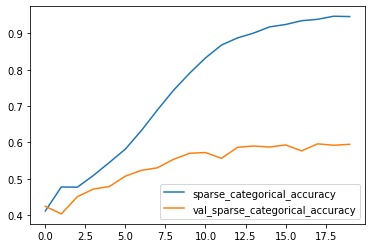

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['sparse_categorical_accuracy','val_sparse_categorical_accuracy'])

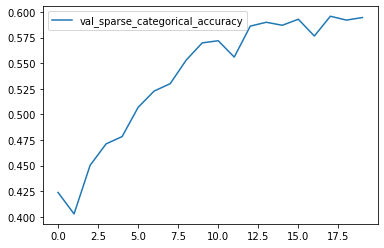

In [22]:
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['val_sparse_categorical_accuracy'])

In [26]:
sentiment_model.save_weights('sentiment_bert_split_ep40.h5')

## 모델 저장된것 불러오기

In [19]:
loaded_model = create_sentiment_bert()
loaded_model.load_weights('sentiment_bert_split_ep20.h5')

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Confusion matrix

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm,3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [29]:
loaded_model = create_sentiment_bert()
loaded_model.load_weights('sentiment_bert_split_ep20.h5')
Y_pred = loaded_model.predict(train_x)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


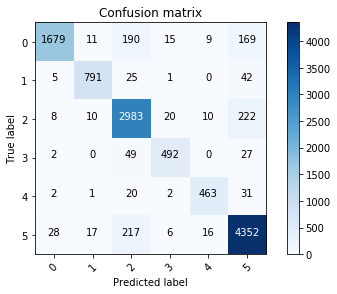

In [33]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(train_y, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(6))

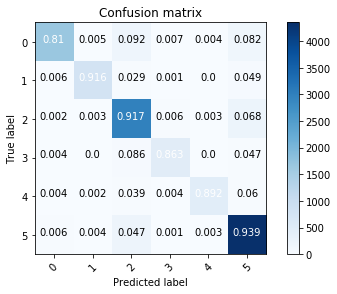

In [34]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(train_y, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(6),normalize = True)

In [10]:
loaded_model = create_sentiment_bert()
loaded_model.load_weights('sentiment_bert_split_ep20.h5')

InternalError: Blas GEMM launch failed : a.shape=(15, 768), b.shape=(768, 768), m=15, n=768, k=768 [Op:MatMul]

In [35]:
loaded_model = create_sentiment_bert()
loaded_model.load_weights('sentiment_bert_split_ep20.h5')
Y_pred = loaded_model.predict(test_x)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


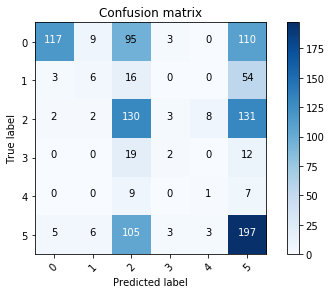

In [36]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(test_y, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(6))

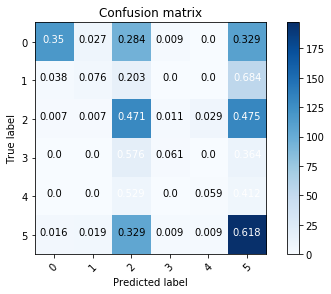

In [37]:
Y_pred_classes = np.argmax(Y_pred, axis = 1)
confusion_mtx = confusion_matrix(test_y, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(6), normalize = True)

In [27]:
# loaded_model.evaluate(train_x,train_y, batch_size = 32)

## Test 및 보완점

In [ ]:
### F1 평가하는 모델 수정 필요

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [ ]:
test_set = predict_load_data(test)

In [ ]:
### 실제 문장 평가하기

In [ ]:
### 문장 한개 평가

In [21]:
def sentence_convert_data(data):
    global tokenizer
    SEQ_LEN = 64
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')
    
    num_zeros = token.count(0) 
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
    segment = [0]*SEQ_LEN

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

def book_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = loaded_model.predict(data_x)
    feeling = 0 
    top_percent = 0 
    for predic in predict:
        for i,pred in enumerate(predic):
            if top_percent < pred : 
                top_percent = pred
                feeling = i 
    print(sentence, predic, feeling, top_percent)

In [69]:
sentence = '공주는 신나게 공놀이를 하고 있었어요'
book_evaluation_predict(sentence)

공주는 신나게 공놀이를 하고 있었어요 [0.49265522 0.02383436 0.222642   0.03967385 0.02397246 0.19722213] 0 0.49265522


In [22]:
sentence = '공주는 신나게 공놀이를 하고 있었어요'
book_evaluation_predict(sentence)

공주는 신나게 공놀이를 하고 있었어요 [0.03506336 0.11728253 0.31055984 0.04082325 0.05901201 0.437259  ] 5 0.437259


In [31]:
sentence = '공주는 신나게 공놀이를 하고 있었어요'
book_evaluation_predict(sentence)

공주는 신나게 공놀이를 하고 있었어요 [0.03506336 0.11728253 0.31055984 0.04082325 0.05901201 0.437259  ] 5 0.437259


In [70]:
### 텍스트 리스트 받아서 문장 여러개 평가 

In [4]:
def multi_book_evaluation_predict(text_list):
    for data in text_list : 
        global tokenizer
        SEQ_LEN = 64
        tokens, masks, segments = [], [], []
        token = tokenizer.encode(data, max_length=SEQ_LEN, truncation=True, padding='max_length')

        num_zeros = token.count(0) 
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros 
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

        tokens = np.array(tokens)
        masks = np.array(masks)
        segments = np.array(segments)
        data_x =  [tokens, masks, segments]
        predict = loaded_model.predict(data_x)
        feeling = 0 
        top_percent = 0
        for predic in predict:
            for i,pred in enumerate(predic):
                if top_percent < pred : 
                    top_percent = pred
                    feeling = i 
        print(data)
        print(predic, feeling, top_percent)
        
        f = open('book_feeling_data_ep20.csv', 'a', newline = '')
        wr = csv.writer(f)
        wr.writerow([data, predic, feeling, top_percent])
    
    
        

In [24]:
import time
%time
text_list = ['별난 재주 삼형제옛날 시골마을에 별난 재주 세 형제가 살았습니다', ' 눈이 밝은 맏이는 별별 것을 다 봅니다', ' 둘째는 천하장사 바윗돌도 번쩍번쩍', ' 개구쟁이 막내는 희한한 재주인데 매 맞는 재주입니다', ' 회초리로 때리면 간지럽다고 깔깔대고 절굿공이 내리치면 시원하다 깔깔댑니다', ' 그러던 어느 날 마을에 흉년이 들어 세 형제는 쫄쫄 굶고 나무뿌리 캐 먹으러 산 위로 올라갔습니다', ' “사람들 어찌 사나 어디 한 번 둘러볼까?” 눈 밝은 맏이가 어허 쯧쯧 혀를 찹니다', ' 논바닥이 쩌억 갈라지고 나무껍질이 홀라당 벗겨져 있었어요', ' 어른들은 굶어서 눈이 움푹 들어가고 아이들은 배고파 울고불고 소리칩니다', ' “으앙 배고파~”그중에서 어디서 밥을 짓나 하얀 연기가 모락모락 피어 오르고 있었어요', ' “마을 사또 사는 곳에 잔치가 열렸구나” 곡간에는 쌀가마니가 산처럼 쌓여 있고 대청마루 상 위에는 온갖 음식이 가득히 차려져 있었어요', ' 땀 흘려 거둔 곡식을 사또 혼자 차지한 것입니다', ' 세 형제는 그 모습을 보고 화가 나서 이리해 볼까, 저리해 볼까 고민을 했습니다', ' 밤은 깊어 가는데 둘째가 쌀가마를 이고 갑니다', ' 이 집 저 집 다니며 배불리 먹으라고 세 형제는 밤새도록 홍길동 노릇을 합니다', ' “야단났네! 야단났어! 곡간이 텅 비었네!” 자신의 곡간이 도둑이 든 것을 안 사또는 소리칩니다', ' 대신 집집마다 밥을 짓는 연기로 하얀 연기가 나오고 있었습니다', ' 욕심 많은 사또는 화가 났습니다', '온 마을 사람들이 끌려와서 성난 사또 눈길을 피해 벌벌 떨고 있는데 막내가 쏜살같이 달려와 “내가 바로 도둑이오!”라고 말을 합니다', ' 결국 막내는 형틀에 묶여 맨 궁둥이 까발리고 철썩 곤장을 맞습니다', ' 사람들은 무서워 벌벌 떠는데 “아 시원하다!”라고 막내는 좋아합니다', ' 한 사람씩 돌아가며 곤장 백 대 내리쳐도 졸린 듯 따분한 듯 막내는 하품을 합니다', ' 오히려 때리는 놈들이 힘들어합니다', ' 보다 못한 사또가 곤장을 칩니다', ' 약이 오른 사또는 날뛰다 뒤로 넘어져 버립니다', ' 결국 지친 사또는 세 형제를 집으로 돌려보내고, 사이 좋은 세 형제는 집으로 돌아갑니다', '신기한 재주를 가진 삼 형제는 자신들의 재주로 굶어가는 마을 사람들을 돕습니다', ' 자신의 장점과 재주가 무엇인지 알고 이를 좋은 곳에 쓴 삼 형제는 우리가 본받아야 할 부분입니다', ' 사또는 자신의 이익만 취하려고 하다가 결국 가지고 있던 것도 모두 잃은 케이스로 과도한 욕심은 오히려 독이 되는 경우가 있습니다', ' 그러므로 우리는 과도한 욕심을 부리지 않는 것은 물론 내가 갖고 있는 장점으로 남을 도울 수 있는 지혜를 기를 수 있는 노력이 필요합니다', '']
multi_book_evaluation_predict(text_list)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
별난 재주 삼형제옛날 시골마을에 별난 재주 세 형제가 살았습니다
[0.03756997 0.12307548 0.30643436 0.03729355 0.06281884 0.4328078 ] 5 0.4328078
 눈이 밝은 맏이는 별별 것을 다 봅니다
[0.01196284 0.0493823  0.4124161  0.07496493 0.02556202 0.4257118 ] 5 0.4257118
 둘째는 천하장사 바윗돌도 번쩍번쩍
[0.0282098  0.09834594 0.33103278 0.05040313 0.04972932 0.44227907] 5 0.44227907
 개구쟁이 막내는 희한한 재주인데 매 맞는 재주입니다
[0.03488404 0.11673518 0.3109756  0.04104551 0.05880781 0.4375519 ] 5 0.4375519
 회초리로 때리면 간지럽다고 깔깔대고 절굿공이 내리치면 시원하다 깔깔댑니다
[0.01213238 0.05016409 0.41160384 0.0742927  0.02602413 0.42578283] 5 0.42578283
 그러던 어느 날 마을에 흉년이 들어 세 형제는 쫄쫄 굶고 나무뿌리 캐 먹으러 산 위로 올라갔습니다
[0.03777425 0.12343074 0.30622146 0.03702946 0.06315632 0.43238777] 5 0.43238777
 “사람들 어찌 사나 어디 한 번 둘러볼까?” 눈 밝은 맏이가 어허 쯧쯧 혀를 찹니다
[0.01249648 0.05148697 0.4087449  0.07377166 0.02707952 0.42642045] 5 0.42642045
 논바닥이 쩌억 갈라지고 나무껍질이 홀라당 벗겨져 있었어요
[0.01406077 0.05704695 0.39799953 0.07187445 0.0303342  0.42868412] 5 0.42868412
 어른

In [37]:
import time
%time
text_list = ['별난 재주 삼형제옛날 시골마을에 별난 재주 세 형제가 살았습니다', ' 눈이 밝은 맏이는 별별 것을 다 봅니다', ' 둘째는 천하장사 바윗돌도 번쩍번쩍', ' 개구쟁이 막내는 희한한 재주인데 매 맞는 재주입니다', ' 회초리로 때리면 간지럽다고 깔깔대고 절굿공이 내리치면 시원하다 깔깔댑니다', ' 그러던 어느 날 마을에 흉년이 들어 세 형제는 쫄쫄 굶고 나무뿌리 캐 먹으러 산 위로 올라갔습니다', ' “사람들 어찌 사나 어디 한 번 둘러볼까?” 눈 밝은 맏이가 어허 쯧쯧 혀를 찹니다', ' 논바닥이 쩌억 갈라지고 나무껍질이 홀라당 벗겨져 있었어요', ' 어른들은 굶어서 눈이 움푹 들어가고 아이들은 배고파 울고불고 소리칩니다', ' “으앙 배고파~”그중에서 어디서 밥을 짓나 하얀 연기가 모락모락 피어 오르고 있었어요', ' “마을 사또 사는 곳에 잔치가 열렸구나” 곡간에는 쌀가마니가 산처럼 쌓여 있고 대청마루 상 위에는 온갖 음식이 가득히 차려져 있었어요', ' 땀 흘려 거둔 곡식을 사또 혼자 차지한 것입니다', ' 세 형제는 그 모습을 보고 화가 나서 이리해 볼까, 저리해 볼까 고민을 했습니다', ' 밤은 깊어 가는데 둘째가 쌀가마를 이고 갑니다', ' 이 집 저 집 다니며 배불리 먹으라고 세 형제는 밤새도록 홍길동 노릇을 합니다', ' “야단났네! 야단났어! 곡간이 텅 비었네!” 자신의 곡간이 도둑이 든 것을 안 사또는 소리칩니다', ' 대신 집집마다 밥을 짓는 연기로 하얀 연기가 나오고 있었습니다', ' 욕심 많은 사또는 화가 났습니다', '온 마을 사람들이 끌려와서 성난 사또 눈길을 피해 벌벌 떨고 있는데 막내가 쏜살같이 달려와 “내가 바로 도둑이오!”라고 말을 합니다', ' 결국 막내는 형틀에 묶여 맨 궁둥이 까발리고 철썩 곤장을 맞습니다', ' 사람들은 무서워 벌벌 떠는데 “아 시원하다!”라고 막내는 좋아합니다', ' 한 사람씩 돌아가며 곤장 백 대 내리쳐도 졸린 듯 따분한 듯 막내는 하품을 합니다', ' 오히려 때리는 놈들이 힘들어합니다', ' 보다 못한 사또가 곤장을 칩니다', ' 약이 오른 사또는 날뛰다 뒤로 넘어져 버립니다', ' 결국 지친 사또는 세 형제를 집으로 돌려보내고, 사이 좋은 세 형제는 집으로 돌아갑니다', '신기한 재주를 가진 삼 형제는 자신들의 재주로 굶어가는 마을 사람들을 돕습니다', ' 자신의 장점과 재주가 무엇인지 알고 이를 좋은 곳에 쓴 삼 형제는 우리가 본받아야 할 부분입니다', ' 사또는 자신의 이익만 취하려고 하다가 결국 가지고 있던 것도 모두 잃은 케이스로 과도한 욕심은 오히려 독이 되는 경우가 있습니다', ' 그러므로 우리는 과도한 욕심을 부리지 않는 것은 물론 내가 갖고 있는 장점으로 남을 도울 수 있는 지혜를 기를 수 있는 노력이 필요합니다', '']
multi_book_evaluation_predict(text_list)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 9.3 µs
별난 재주 삼형제옛날 시골마을에 별난 재주 세 형제가 살았습니다
[0.03756997 0.12307548 0.30643436 0.03729355 0.06281884 0.4328078 ] 5 0.4328078
 눈이 밝은 맏이는 별별 것을 다 봅니다
[0.01196284 0.0493823  0.4124161  0.07496493 0.02556202 0.4257118 ] 5 0.4257118
 둘째는 천하장사 바윗돌도 번쩍번쩍
[0.0282098  0.09834594 0.33103278 0.05040313 0.04972932 0.44227907] 5 0.44227907
 개구쟁이 막내는 희한한 재주인데 매 맞는 재주입니다
[0.03488404 0.11673518 0.3109756  0.04104551 0.05880781 0.4375519 ] 5 0.4375519
 회초리로 때리면 간지럽다고 깔깔대고 절굿공이 내리치면 시원하다 깔깔댑니다
[0.01213238 0.05016409 0.41160384 0.0742927  0.02602413 0.42578283] 5 0.42578283
 그러던 어느 날 마을에 흉년이 들어 세 형제는 쫄쫄 굶고 나무뿌리 캐 먹으러 산 위로 올라갔습니다
[0.03777425 0.12343074 0.30622146 0.03702946 0.06315632 0.43238777] 5 0.43238777
 “사람들 어찌 사나 어디 한 번 둘러볼까?” 눈 밝은 맏이가 어허 쯧쯧 혀를 찹니다
[0.01249648 0.05148697 0.4087449  0.07377166 0.02707952 0.42642045] 5 0.42642045
 논바닥이 쩌억 갈라지고 나무껍질이 홀라당 벗겨져 있었어요
[0.01406077 0.05704695 0.39799953 0.07187445 0.0303342  0.42868412] 5 0.42868412
 어